In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv("data_daily.csv")
print(data)
device = "cuda" if torch.cuda.is_available() else "cpu"

data = data["Receipt_Count"].values.astype(float)




         # Date  Receipt_Count
0    2021-01-01        7564766
1    2021-01-02        7455524
2    2021-01-03        7095414
3    2021-01-04        7666163
4    2021-01-05        7771289
..          ...            ...
360  2021-12-27       10350408
361  2021-12-28       10219445
362  2021-12-29       10313337
363  2021-12-30       10310644
364  2021-12-31       10211187

[365 rows x 2 columns]


In [3]:
def normalize(data):
    data_min = np.min(data)
    data_max = np.max(data)
    return (data - data_min) / (data_max - data_min + 1e-7), data_min, data_max

def denormalize(data, data_min, data_max):
    return data * (data_max - data_min + 1e-7) + data_min

normalized_data, data_min, data_max = normalize(data)

In [4]:
def create_sequence(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i: i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
X, y = create_sequence(normalized_data, 12)
train_size = int(len(X) * 0.9)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32).to(device=device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device=device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device=device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device=device)

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size = 1, hidden_layer_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
    
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq),1,-1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]


In [6]:
# model = LSTMModel().to(device=device)
# loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# epochs=20

# y_train = y_train.view(-1, 1)
# for epoch in range(1, epochs+1):
#     for seq, label in zip(X_train, y_train):

#         seq=seq.to(device=device)
#         label = label.to(device=device)

#         optimizer.zero_grad()
#         model.hidden_cell = (torch.zeros(1,1,model.hidden_layer_size).to(device),
#                              torch.zeros(1,1,model.hidden_layer_size).to(device))
#         y_pred = model(seq)

#         y_pred = y_pred.view(-1)

#         loss = loss_function(y_pred, label)

#         loss.backward()
#         optimizer.step()
#     if epoch % 5 == 0:
#         print(f'Epoch {epoch} Loss: {loss.item()}')

model = LSTMModel().to(device=device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train the model with training set and validate on validation set
epochs = 50
y_train = y_train.view(-1, 1)
y_val = y_val.view(-1, 1)

for epoch in range(1, epochs + 1):
    model.train()  # Training mode
    for seq, label in zip(X_train, y_train):
        seq, label = seq.to(device=device), label.to(device=device)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                             torch.zeros(1, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)
        y_pred = y_pred.view(-1)
        loss = loss_function(y_pred, label)
        loss.backward()
        optimizer.step()

    # Validation at each epoch
    if epoch % 5 == 0:
        model.eval()  # Evaluation mode
        val_loss = 0
        with torch.inference_mode():
            for seq, label in zip(X_val, y_val):
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                                     torch.zeros(1, 1, model.hidden_layer_size).to(device))
                y_pred = model(seq)
                val_loss += loss_function(y_pred.view(-1), label).item()
        print(f'Epoch {epoch} | Train Loss: {loss.item()} | Validation Loss: {val_loss / len(X_val)}')

Epoch 5 | Train Loss: 0.0036417844239622355 | Validation Loss: 0.005662160753925289
Epoch 10 | Train Loss: 0.003926885314285755 | Validation Loss: 0.005795285243518972
Epoch 15 | Train Loss: 0.003868685569614172 | Validation Loss: 0.005831807541663163
Epoch 20 | Train Loss: 0.00381848169490695 | Validation Loss: 0.005816892940517151
Epoch 25 | Train Loss: 0.003769652219489217 | Validation Loss: 0.0057950442576135686
Epoch 30 | Train Loss: 0.003720271633937955 | Validation Loss: 0.005774424047015497
Epoch 35 | Train Loss: 0.003668746678158641 | Validation Loss: 0.005755784050311124
Epoch 40 | Train Loss: 0.0036162191536277533 | Validation Loss: 0.005739024525636991
Epoch 45 | Train Loss: 0.003565635997802019 | Validation Loss: 0.005724228587452116
Epoch 50 | Train Loss: 0.0035187317989766598 | Validation Loss: 0.0057114705905942425


In [7]:
with torch.inference_mode():
    model.eval()
    predictions = []
    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
    for seq in torch.cat((X_train, X_val), dim=0):
        pred = model(seq)
        predictions.append(pred.item())

predicted_receipts = denormalize(np.array(predictions), data_min, data_max)
print(len(predicted_receipts))
print(predicted_receipts)

353
[ 7761469.61654129  7848261.71514956  7900573.51217809  7906964.34525139
  7904057.67885873  7894185.77372887  7917790.75189138  7885618.9312974
  7861762.41991741  7875395.81347946  7907239.8210868   7911201.10279339
  7894418.14199366  7860171.45738668  7809415.33331596  7818758.11201856
  7819779.55513394  7832560.02686424  7865716.91516767  7923441.53547464
  7951045.14799938  7965905.15282463  7979688.98855064  7975989.0668503
  7986383.69199265  7966642.16198225  8005361.12131176  8031968.86208859
  8055097.10526672  8048793.84462592  8058666.99846375  8066571.211299
  8103638.83578226  8125979.08994281  8142878.23487493  8161813.64245644
  8189254.38002923  8229967.47168723  8224147.18957064  8215469.86363009
  8204516.84886077  8254637.9234938   8285351.68751785  8303581.95514068
  8318697.61934886  8333885.3828691   8335107.05359209  8349571.76090894
  8349998.27611647  8363123.0654952   8362625.86255852  8375780.72951171
  8395989.05913443  8412515.32900987  8421279.63017

In [8]:
def predict_sequence(model, normalized_data, num_days):

    future_predictions = []

    current_seq = torch.tensor(normalized_data[:12], dtype=torch.float32).to(device=device)

    model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

    for _ in range(num_days):
        with torch.inference_mode():
            model.eval()
            pred = model(current_seq)
            future_predictions.append(pred.item())

            current_seq = torch.cat((current_seq[1:], pred.view(1)), dim=0)
    
    return future_predictions



predicted_first_12_days = denormalize(np.array(predict_sequence(model, normalized_data, 12)), data_min, data_max)
predicted_first_12_days

array([7761469.61654129, 7817344.14026896, 7862886.25708593,
       7927356.50640322, 7974850.51664446, 8016865.57637676,
       8076313.84800866, 8127575.59022191, 8184767.60943598,
       8269726.98479316, 8371788.230106  , 8470365.36302985])

In [9]:
torch.save(model.state_dict(), 'timeseries_predictor2.pth')


In [10]:
predicted_receipts_full = np.concatenate((predicted_first_12_days, predicted_receipts))


In [11]:
months_2022 = {}
months_2022["January"] = int(predicted_receipts_full[0:31].sum())
months_2022["February"] = int(predicted_receipts_full[31:59].sum())
months_2022["March"] = int(predicted_receipts_full[59:90].sum())
months_2022["April"] = int(predicted_receipts_full[90:120].sum())
months_2022["May"] = int(predicted_receipts_full[120:151].sum())
months_2022["June"] = int(predicted_receipts_full[151:181].sum())
months_2022["July"] = int(predicted_receipts_full[181:212].sum())
months_2022["August"] = int(predicted_receipts_full[212:243].sum())
months_2022["September"] = int(predicted_receipts_full[243:273].sum())
months_2022["October"] = int(predicted_receipts_full[273:304].sum())
months_2022["November"] = int(predicted_receipts_full[304:334].sum())
months_2022["December"] = int(predicted_receipts_full[334:365].sum())

months_2021 = {}
months_2021["January"] = int(data[0:31].sum())
months_2021["February"] = int(data[31:59].sum())
months_2021["March"] = int(data[59:90].sum())
months_2021["April"] = int(data[90:120].sum())
months_2021["May"] = int(data[120:151].sum())
months_2021["June"] = int(data[151:181].sum())
months_2021["July"] = int(data[181:212].sum())
months_2021["August"] = int(data[212:243].sum())
months_2021["September"] = int(data[243:273].sum())
months_2021["October"] = int(data[273:304].sum())
months_2021["November"] = int(data[304:334].sum())
months_2021["December"] = int(data[334:365].sum())
print(months_2021)
print(months_2022)

{'January': 236736687, 'February': 220033460, 'March': 248608625, 'April': 250644830, 'May': 263151748, 'June': 260656840, 'July': 274776003, 'August': 283943231, 'September': 281146154, 'October': 295965185, 'November': 296085162, 'December': 309948684}
{'January': 246336651, 'February': 227444482, 'March': 262312314, 'April': 269551929, 'May': 292595181, 'June': 292207263, 'July': 313326552, 'August': 325315891, 'September': 323547828, 'October': 339684427, 'November': 335978488, 'December': 351550550}


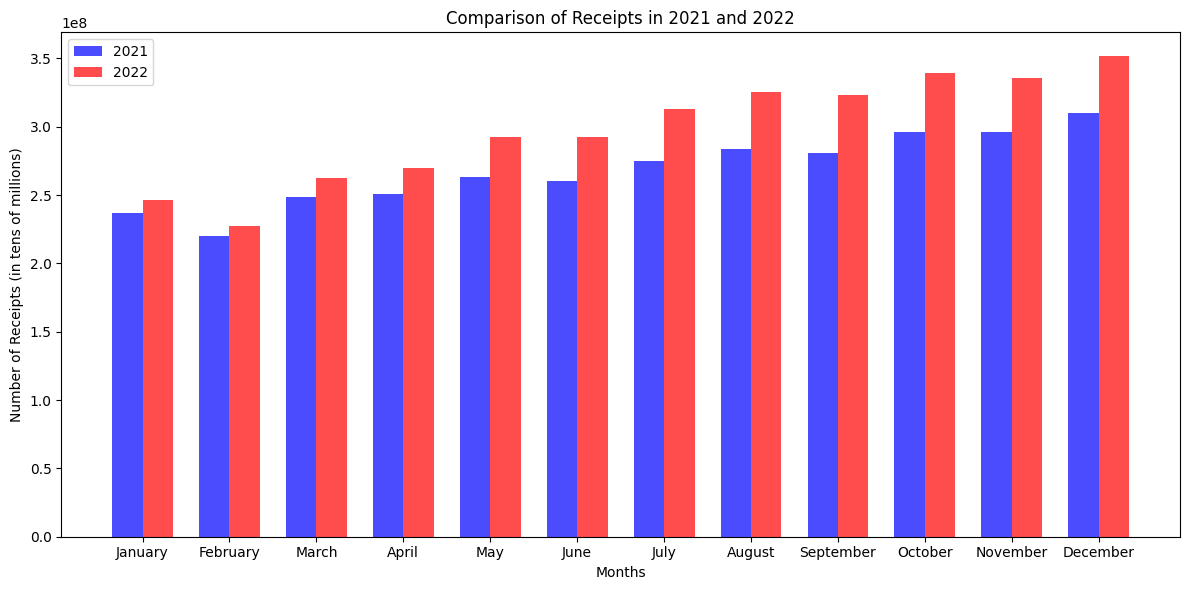

In [12]:
import matplotlib.pyplot as plt

# Extract months and their corresponding sums for 2021 and 2022
months = list(months_2021.keys())
amounts_2021 = list(months_2021.values())
amounts_2022 = list(months_2022.values())

# Set the figure size
plt.figure(figsize=(12, 6))

# Define bar width
bar_width = 0.35

# Define the positions of the bars on the x-axis
x = range(len(months))

# Create bars for 2021 and 2022
bars_2021 = plt.bar(x, amounts_2021, width=bar_width, label='2021', color='b', alpha=0.7)
bars_2022 = plt.bar([p + bar_width for p in x], amounts_2022, width=bar_width, label='2022', color='r', alpha=0.7)

# Adding labels and title
plt.xlabel('Months')
plt.ylabel('Number of Receipts (in tens of millions)')
plt.title('Comparison of Receipts in 2021 and 2022')
plt.xticks([p + bar_width / 2 for p in x], months)  # Set x-ticks to be in the center of the grouped bars
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [13]:
print(torch.__version__)

2.2.2
